In [1]:
# dataset can be obtained via https://zenodo.org/record/4596345#.Yk2flG5Bz0o
# folder containing one or more sub-folders 
# sub-folders are publications
# within each sub-folder, collection of text files that each constitute a document
# for now, supported naming pattern for text files is as such: '/sn86069873/1900-01-05/'
# LCCN title information and publication date (yyyy-mm-dd)
# users will need to provide publication names that match title information, or to use the metadata file

In [2]:
# indicate name of the folder containing data for ex 'data_tm_workflow'
folder_path = '/Users/mariella.decrouychan/Documents/TM/CI_newspaper_subcorpora'

In [3]:
# create a folder for ex 'output_tm_workflow' to store the output files
output_folder = '/Users/mariella.decrouychan/Documents/TM/output_tm_workflow'

# 1. Data preparation

In [4]:
import os
import pandas as pd
import re
#import datetime
#from datetime import date # timedelta, 

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [5]:
publications_list = os.listdir(folder_path) 

In [6]:
# remove DS_store files for mac OS
publications_list = [ file for file in publications_list if '.DS_Store' not in file ]

In [7]:
files_list = []

for pub in publications_list:
    files = os.listdir(f"{folder_path}/{pub}/")
    files = [ f"/{pub}/{file}" for file in files ]
    files_list.append(files)

In [8]:
# var files_list is alist of lists and needs to be transformed into one list
files_list_flat = [item for sublist in files_list for item in sublist]

In [9]:
#insert file names into a df
sources = pd.DataFrame(files_list_flat, columns=['file_name'])

In [10]:
sources.head()

,file_name
0,/L'Italia/sn85066408_1913-03-10_ed-1_seq-1_ocr...
1,/L'Italia/sn85066408_1910-06-16_ed-1_seq-1_ocr...
2,/L'Italia/sn85066408_1915-05-09_ed-1_seq-1_ocr...
3,/L'Italia/sn85066408_1898-03-22_ed-1_seq-1_ocr...
4,/L'Italia/sn85066408_1911-09-01_ed-1_seq-1_ocr...


## 1.2. Adding metadata elements into dataframe

### 1.2.1. Get metadata from metadata file if present (or, alternatively, run step 1.2.2)

In [11]:
# get metadata file
# The ChroniclItaly metadata file can be downloaded here: https://zenodo.org/record/4596345/files/Metadata_ChroniclItaly%203.0.xlsx?download=1
metadata_file_path = '/Users/mariella.decrouychan/Documents/TM/Metadata_ChroniclItaly 3.0.xlsx'

In [12]:
metadata_df = pd.read_excel(metadata_file_path, header=1)

In [13]:
metadata_df

,Title,Place of publication,Publisher,Issues,Number of issues,Total words before intervention,Total words after intervention,Description,Frequency,LCCN,OCLC,ISSN,Related Links,Holdings,History,Notes
0,La sentinella del West Virginia,"Thomas, W. Va.",Sentinel Publ. Co.,From 18/02/1911 to 11/05/1912,53,124988,86839,"Began in Feb., 1905 - Ceased in 1913?",Weekly,sn 86092310,13261125,2473-4918,http://chroniclingamerica.loc.gov/lccn/sn86092...,https://chroniclingamerica.loc.gov/lccn/sn8609...,"West Virginia’s only Italian periodical, La Se...","""Giornale independente."" ""Primo ed unico perio..."
1,L'Italia,"San Francisco, Calif.",Italian Pub. Co.,From 25/01/1897 to 31/12/1919,"6,489",24584681,17123478,"58mo anno, n. 27 (genn. 31, 1943)\nBegan in 1887",Daily (except Sun. and Mon.),sn 85066408,13073199,/,/,https://chroniclingamerica.loc.gov/lccn/sn8506...,Alternative Titles:\nDaily news\nItalia di Dom...,"Description based on: Vol. 3, no. 12 (genn. 28..."
2,"Cronaca Sovversiva (Barre, Vt.)","Barre, Vt.",Cronaca Sovversiva,From 06/06/1903 to 01/05/1919,771,1825758,1289239,"Ceased in 1920.\nVol. 1, no. 1 (June 6, 1903)-","Weekly Jan. 17, 1920-<Oct. 20, 1920>",2012271201,30383424,2376-3701,http://chroniclingamerica.loc.gov/lccn/2012271...,https://chroniclingamerica.loc.gov/lccn/201227...,Subjects covered: Anarchism--Italy--Periodical...,Archived issues are available in digital forma...
3,La Libera Parola,"Philadelphia, Pa.",A.G. di Silvestro,From 20/04/1918 to 23/12/1922,241,1079122,752309,"20 apr., 1918-July 19, 1969",Weekly,sn 85055164,12632841,2373-373X,http://www.loc.gov/chroniclingamerica/lccn/sn8...,https://chroniclingamerica.loc.gov/lccn/sn8505...,In 1899 Arpino Di Silvestro began publishing a...,"""Italian weekly newspaper.""\n""Published every ..."
4,Il Patriota,"Indiana, Pa.",Patriot Pub. Co.,From 08/08/1914 to 22/10/1921,227,786762,547361,"Ceased in Dec. 1955?\nVol. 1, no. 1 (Aug. 8, 1...",Weekly,sn 85054967,2265753,2373-3713,http://www.loc.gov/chroniclingamerica/lccn/sn8...,https://chroniclingamerica.loc.gov/lccn/sn8505...,Westmoreland and Lycoming Counties provided la...,"""Settimanale indipente bilingue,"" <Aug. 2, 191..."
5,La Ragione,"Philadelphia, Pa.",F. Silvagni,From 25/04/1917 to 23/08/1917,40,126937,86588,"Anno 1, no. 1 (25 apr. 1917)-",Irregular,sn 84037024,10916544,2372-9872,http://www.loc.gov/chroniclingamerica/lccn/sn8...,https://chroniclingamerica.loc.gov/lccn/sn8403...,"Founded in 1917, La Ragione (“The Reason”) was...","""Organo di difesa della italianita, contro i v..."
6,La Rassegna,"Philadelphia, Pa.",La Rassegna Pub. Co.,From 07/04/1917 to 25/08/1917,25,86401,60116,"Anno 1, no. 1 (7 apr. 1917)-",Weekly (irregular),sn 84037025,10916483,2372-9910,http://www.loc.gov/chroniclingamerica/lccn/sn8...,https://chroniclingamerica.loc.gov/lccn/sn8403...,La Rassegna (“The Review”) was a short-lived w...,"""Italian weekly newspaper devoted to welfare a..."
7,L'Indipendente,"New Haven, Conn.",L'indipendente Pub. Co.,From 01/01/1907 to 23/05/1936,48,133872,90758,Began in 1903,Weekly,sn 93053873,27774408,2643-3095,https://chroniclingamerica.loc.gov/lccn/sn9305...,https://chroniclingamerica.loc.gov/lccn/sn9305...,"Headquartered in Wooster Square, one of two ne...","""Established 1903""--Genn. 22, 1922 issue. Also..."
8,La Sentinella,"Bridgeport, Conn.",P. Alteri,From 17/04/1920 to 27/12/1930,518,1674336,1193015,"-anno. 35, no. 36 (10 sett. 1948)",Weekly,sn 84020351,10652874,2643-5098,http://www.loc.gov/chroniclingamerica/lccn/sn8...,https://chroniclingamerica.loc.gov/lccn/sn8402...,"In November 1977, the Bridgeport Post noted th...",Archived issues are available in digital forma...
9,La Tribuna del Connecticut,"Bridgeport, Conn.",Tribuna Pub. Co.,From 03/03/1906 to 09/12/1908,130,330085,224752,"Anno 1, no. 1 (mar. 3, 1906)-anno 2, no. 44 (d...",Weekly,sn 92051386,26498347,2643-5306,http://www.loc.gov/chroniclingamerica/lccn/sn9...,https://chroniclingamerica.loc.gov/lccn/sn9205...,"In the inaugural March, 1906 issue of L

In [14]:
#LCCN column contains spaces that need to be removed
pub_refs = list(metadata_df['LCCN'].str.replace(" ", ""))
pub_names = list(metadata_df['Title'])

### 1.2.2. If metadata file not present, create mapping for publications name / publications reference

In [15]:
# order of refs and names needs to match
pub_refs = ["2012271201","sn85054967","sn93053873","sn85066408","sn85055164","sn84037024","sn84037025","sn84020351","sn86092310","sn92051386"]
pub_names = ["Cronaca_Sovversiva","Il_Patriota","L'Indipendente","L'Italia","La_Libera_Parola","La_Ragione","La_Rassegna","La_Sentinella","La_Sentinella_del_West","La_Tribuna_del_Connecticut"]

### 1.2.3. Add dates, and publications references from file names for each document in dataframe


In [16]:
# get publication reference from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

# get date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]


#this part probably not needed
'''
# get year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# get month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

# get day from file name
def get_day(file):
  month_match = re.findall(r'_\d{4}-\d{2}-(\d{2})_',file)
  return month_match[0]
'''

"\n# get year from file name\ndef get_year(file):\n  year_match = re.findall(r'_(\\d{4})-\\d{2}-\\d{2}_',file)\n  return year_match[0]\n\n# get month from file name\ndef get_month(file):\n  month_match = re.findall(r'_\\d{4}-(\\d{2})-\\d{2}_',file)\n  return month_match[0]\n\n# get day from file name\ndef get_day(file):\n  month_match = re.findall(r'_\\d{4}-\\d{2}-(\\d{2})_',file)\n  return month_match[0]\n"

In [17]:
sources['date'] = sources['file_name'].apply(lambda x: get_date(x))
sources['publication_ref'] = sources['file_name'].apply(lambda x: get_ref(x))
sources["date"] = pd.to_datetime(sources["date"])

#sources['year'] = sources['file_name'].apply(lambda x: get_year(x))
#sources['month'] = sources['file_name'].apply(lambda x: get_month(x))
#sources['day'] = sources['file_name'].apply(lambda x: get_day(x))

### 1.2.4. Add publication names into dataframe

In [18]:
sources['publication_name'] = sources['publication_ref'].replace(pub_refs, pub_names)

In [19]:
sources.head()

,file_name,date,publication_ref,publication_name
0,/L'Italia/sn85066408_1913-03-10_ed-1_seq-1_ocr...,1913-03-10,sn85066408,L'Italia
1,/L'Italia/sn85066408_1910-06-16_ed-1_seq-1_ocr...,1910-06-16,sn85066408,L'Italia
2,/L'Italia/sn85066408_1915-05-09_ed-1_seq-1_ocr...,1915-05-09,sn85066408,L'Italia
3,/L'Italia/sn85066408_1898-03-22_ed-1_seq-1_ocr...,1898-03-22,sn85066408,L'Italia
4,/L'Italia/sn85066408_1911-09-01_ed-1_seq-1_ocr...,1911-09-01,sn85066408,L'Italia


In [20]:
sources.tail()

,file_name,date,publication_ref,publication_name
8648,/La_Ragione/sn84037024_1917-07-24_ed-5_seq-1_o...,1917-07-24,sn84037024,La_Ragione
8649,/La_Ragione/sn84037024_1917-05-05_ed-3_seq-1_o...,1917-05-05,sn84037024,La_Ragione
8650,/La_Ragione/sn84037024_1917-06-30_ed-2_seq-1_o...,1917-06-30,sn84037024,La_Ragione
8651,/La_Ragione/sn84037024_1917-07-24_ed-1_seq-1_o...,1917-07-24,sn84037024,La_Ragione
8652,/La_Ragione/sn84037024_1917-05-16_ed-4_seq-1_o...,1917-05-16,sn84037024,La_Ragione


In [21]:
# checking that there is no empty values
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8653 entries, 0 to 8652
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   file_name         8653 non-null   object        
 1   date              8653 non-null   datetime64[ns]
 2   publication_ref   8653 non-null   object        
 3   publication_name  8653 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 270.5+ KB


### 1.3. Creating a subset of the dataset

- Setting-up a visualization to assist in choosing the dates by showing the number of documents available by collection and by date 

In [22]:
import duckdb
from observable_jupyter import embed
import ipywidgets as widgets
from ipywidgets import HBox, VBox

In [23]:
# Setting up inputs widgets
# The "agg" input has an impact on data preparation, as it will determine how the collection is aggregated
# All other inputs are for display purpose only and they don't have an impact on data 
color = widgets.RadioButtons(
    description='Color',
    options= ['blue', 'green', 'grey', 'orange'],
    value='blue',
)

agg = widgets.RadioButtons(
    description='Count articles by:',
    options= ['day', 'month', 'year'],
    value='month',
)

scale = widgets.RadioButtons(
    description='Scale by:',
    options= ['height', 'color'],
    value='color',
)

label = widgets.RadioButtons(
    description='Set-up ticks scale',
    options= ['5 year', 'year', 'month', 'day'],
    value='year',
)

In [24]:
def prepare_viz_data(agg, df, col):

    if agg == 'month':
        query = f"SELECT strptime(concat(month, '/', year), '%m/%Y') as date, {col} as publication_name, count FROM (SELECT YEAR(date) as year, MONTH(date) as month, {col}, count(*) as count FROM df GROUP BY {col}, YEAR(date), MONTH(date))"

    elif agg == 'year':
        query = f"SELECT strptime(year, '%Y') as date, {col} as publication_name, count FROM (SELECT YEAR(date) as year, {col}, count(*) as count FROM df GROUP BY {col}, YEAR(date))"

    elif agg == 'day':
        query = f"SELECT strptime(concat('01/', month, '/', year), '%d/%m/%Y') as date, {col} as publication_name, count FROM (SELECT YEAR(date) as year, MONTH(date) as month, {col}, count(*) as count FROM df GROUP BY {col}, YEAR(date), MONTH(date), DAY(date))"

    queried_df = duckdb.query(query).df()

    queried_df = queried_df.astype(str)

    viz_data = queried_df.to_dict('records')

    return viz_data

    

In [25]:
# user inputs
left_box = VBox([color, agg])
right_box = VBox([scale, label])
HBox([left_box, right_box])

In [26]:
# the column on which the aggregation will be performed, here we count the articles for each publication accross time
col = "publication_name"

In [27]:
# rerun this cell after modifying inputs
embed('@dharpa-project/timestamped-corpus', cells=['viewof chart', 'style'], inputs={'data':prepare_viz_data(agg.value, sources, col), "timeSelected":agg.value, "userColor":color.value, "scaleType":scale.value})


<i>(Screenshot for Github since interactive content is not displayed by Github)</i>

<img src='img/corpus_preview.png'>

- Apply filter to dataset

In [28]:
# Start from 06.06.1903 and finish 01.05.1919
date_ref_1 = "1903-6-6"
date_ref_2 = "1919-5-1"

In [29]:
query = f"SELECT * FROM sources WHERE date <= DATE '{date_ref_2}' AND date > DATE '{date_ref_1}'"

In [30]:
subset_df = duckdb.query(query).df()

In [31]:
subset_df

,file_name,date,publication_ref,publication_name
0,/L'Italia/sn85066408_1913-03-10_ed-1_seq-1_ocr...,1913-03-10,sn85066408,L'Italia
1,/L'Italia/sn85066408_1910-06-16_ed-1_seq-1_ocr...,1910-06-16,sn85066408,L'Italia
2,/L'Italia/sn85066408_1915-05-09_ed-1_seq-1_ocr...,1915-05-09,sn85066408,L'Italia
3,/L'Italia/sn85066408_1911-09-01_ed-1_seq-1_ocr...,1911-09-01,sn85066408,L'Italia
4,/L'Italia/sn85066408_1904-11-30_ed-1_seq-1_ocr...,1904-11-30,sn85066408,L'Italia
...,...,...,...,...
6520,/La_Ragione/sn84037024_1917-07-24_ed-5_seq-1_o...,1917-07-24,sn84037024,La_Ragione
6521,/La_Ragione/sn84037024_1917-05-05_ed-3_seq-1_o...,1917-05-05,sn84037024,La_Ragione
6522,/La_Ragione/sn84037024_1917-06-30_ed-2_seq-1_o...,1917-06-30,sn84037024,La_Ragione
6523,/La_Ragione/sn84037024_1917-07-24_ed-1_seq-1_o...,1917-07-24,sn84037024,La_Ragione


- Visual check that the query went ok

In [32]:
embed('@dharpa-project/timestamped-corpus', cells=['viewof chart', 'style'], inputs={'data':prepare_viz_data(agg.value, subset_df, col), "timeSelected":agg.value, "userColor":color.value, "scaleType":scale.value})


<i>(Screenshot for Github since interactive content is not displayed by Github)</i>

<img src='img/subset_check.png'/>

### 1.4. Adding text content of the documents to the dataframe

In [33]:
# read the content of the text files
def readTxtContent(fileName):
  with open(folder_path + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [34]:
subset_df

,file_name,date,publication_ref,publication_name
0,/L'Italia/sn85066408_1913-03-10_ed-1_seq-1_ocr...,1913-03-10,sn85066408,L'Italia
1,/L'Italia/sn85066408_1910-06-16_ed-1_seq-1_ocr...,1910-06-16,sn85066408,L'Italia
2,/L'Italia/sn85066408_1915-05-09_ed-1_seq-1_ocr...,1915-05-09,sn85066408,L'Italia
3,/L'Italia/sn85066408_1911-09-01_ed-1_seq-1_ocr...,1911-09-01,sn85066408,L'Italia
4,/L'Italia/sn85066408_1904-11-30_ed-1_seq-1_ocr...,1904-11-30,sn85066408,L'Italia
...,...,...,...,...
6520,/La_Ragione/sn84037024_1917-07-24_ed-5_seq-1_o...,1917-07-24,sn84037024,La_Ragione
6521,/La_Ragione/sn84037024_1917-05-05_ed-3_seq-1_o...,1917-05-05,sn84037024,La_Ragione
6522,/La_Ragione/sn84037024_1917-06-30_ed-2_seq-1_o...,1917-06-30,sn84037024,La_Ragione
6523,/La_Ragione/sn84037024_1917-07-24_ed-1_seq-1_o...,1917-07-24,sn84037024,La_Ragione


In [35]:
# we are now using the subset to continue working
# add a column to the dataframe containing file content
subset_df['file_content'] = subset_df['file_name'].apply(lambda x: readTxtContent(x))
subset_df['chars_count'] = subset_df['file_content'].apply(lambda x: len(x))
subset_df['words_count'] = subset_df['file_content'].apply(lambda x: len(x.split()))

In [36]:
subset_df

,file_name,date,publication_ref,publication_name,file_content,chars_count,words_count
0,/L'Italia/sn85066408_1913-03-10_ed-1_seq-1_ocr...,1913-03-10,sn85066408,L'Italia,anno xxvil rpiù VECCHIO E DIFPUSO QUOTIDIANO ...,24810,4229
1,/L'Italia/sn85066408_1910-06-16_ed-1_seq-1_ocr...,1910-06-16,sn85066408,L'Italia,"(,1oììiìiI<‘ IliiUnno fatto |ht gl'italiani V...",27916,4762
2,/L'Italia/sn85066408_1915-05-09_ed-1_seq-1_ocr...,1915-05-09,sn85066408,L'Italia,SUNDAY ED1TION IL PIU VECCHIO E DlfFbSO QUOTI...,17803,2921
3,/L'Italia/sn85066408_1911-09-01_ed-1_seq-1_ocr...,1911-09-01,sn85066408,L'Italia,? Giornale italiano fatto f>er gTItaliani ! I...,27383,4653
4,/L'Italia/sn85066408_1904-11-30_ed-1_seq-1_ocr...,1904-11-30,sn85066408,L'Italia,I A e umanità 7i«ST ITALIANI DAILY ON TUE PAC...,19680,3309
...,...,...,...,...,...,...,...
6520,/La_Ragione/sn84037024_1917-07-24_ed-5_seq-1_o...,1917-07-24,sn84037024,La_Ragione,"LA RAGIONE contro i vili, i camorristi, i sic...",19982,3443
6521,/La_Ragione/sn84037024_1917-05-05_ed-3_seq-1_o...,1917-05-05,sn84037024,La_Ragione,LA RAGIONE ORGANO DI DIFESA DELLA ITALIANITÀ'...,18182,3127
6522,/La_Ragione/sn84037024_1917-06-30_ed-2_seq-1_o...,1917-06-30,sn84037024,La_Ragione,"LA RAGIONE contro i vili, i camorristi, i sic...",14906,2521
6523,/La_Ragione/sn84037024_1917-07-24_ed-1_seq-1_o...,1917-07-24,sn84037024,La_Ragione,ORGANO DI DIFESA DELLA ITAI ANITA contro i vi...,19738,3451


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

In [96]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=.7)

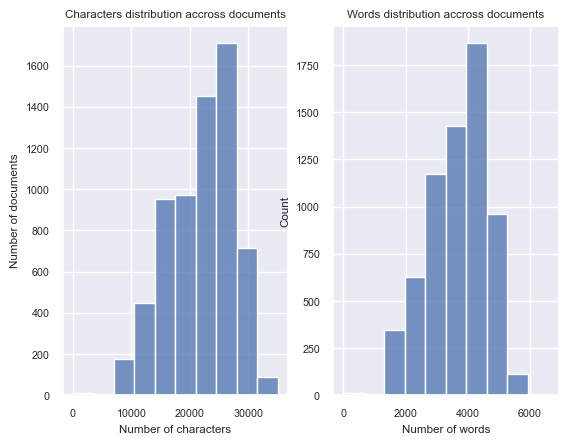

In [97]:
f, axes = plt.subplots(1, 2)
sns.histplot(subset_df.chars_count, bins=10, ax=axes[0]).set(title='Characters distribution accross documents', xlabel='Number of characters', ylabel='Number of documents')
sns.histplot(subset_df.words_count, bins=10, ax=axes[1]).set(title='Words distribution accross documents', xlabel='Number of words')
plt.show()

<Axes: xlabel='chars_count', ylabel='words_count'>

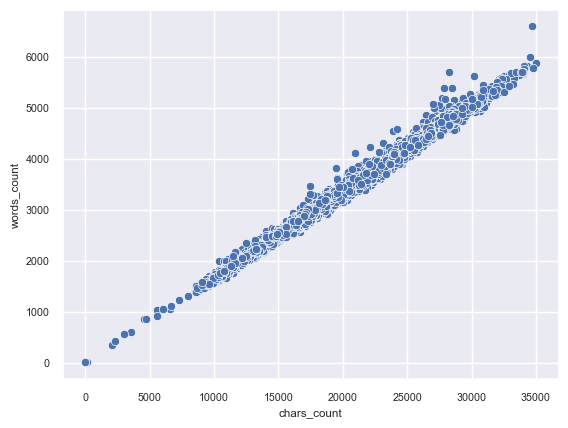

In [98]:
sns.scatterplot(data=subset_df, x="chars_count", y="words_count")

In [47]:
#subset_df.to_csv(output_folder + '/documents_list.csv')

## 1.5 Corpus pre-processing

In [48]:
# As LDA is sensitive to noise https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/
# pre-processing the corpus may be necessary when using this methodology 

In [102]:
# if a subset has been created at previous step, setting the subset as input for corpus variable in this next step
corpus_df = subset_df
# otherwise
# corpus_df = sources

In [103]:
# we're also creating a "sample" variable to have a random sample of the dataframe on which it is possible to test data transformation processes
# before applying them to the whole corpus
sample = corpus_df['file_content'].sample(n=15, random_state=1)

In [104]:
sample

4832     11 ’ AIR< Camera sono •' ; 11 i pochissimi de...
413      ♦‘PublL-trtcdjuid distributed under permit No...
2932     anvo xxvm. (i pii) VECCHIO C Dlf»»SO QUOTIDIA...
3400     anno xxvn. UOMINI E COSE DEL GIORNO (Note • c...
4903     anno XXXI fib VECCHIO C DlffUSO QUOTIDIANO IT...
3628     Spatria e umanità fIBST ITALIAN DAILY ON TNf ...
994      * > " r " nM " ni ” K °- 88 “**■“* b -' Art »...
3667     "PATRIA E UMANITÀ niST ITAIUN DAIIY «NINI PAC...
4411     PATRIA E UMANITÀ riusi ITALIANI DAILY OKI IME...
5473     * %% %% %% %% \\\\ %% v% *<*% \%\V9 M L PATRI...
1373     fPATRIA E UMANITÀ' nm ITALIA* DAILY ON THE PA...
1321     A VIVO V\ M ' 1 " ' A flU VECCHIO C DIFFUSO Q...
5078     “P"biishM and distributed under permit No. 88...
3708     PATRIA E UMANITÀ MUST ITAIIAN DAILY ON THE PA...
5319     Perche' al mirare degl' astri fulgenti . dei ...
Name: file_content, dtype: object

### 1.5.1. Case, characters and stop words

In [105]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariella.decrouychan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariella.decrouychan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
sample_tokenized = sample.apply(lambda x: nltk.word_tokenize(x))

In [107]:
sample_tokenized

4832    [11, ’, AIR, <, Camera, sono, •, ', ;, 11, i, ...
413     [♦, ‘, PublL-trtcdjuid, distributed, under, pe...
2932    [anvo, xxvm, ., (, i, pii, ), VECCHIO, C, Dlf,...
3400    [anno, xxvn, ., UOMINI, E, COSE, DEL, GIORNO, ...
4903    [anno, XXXI, fib, VECCHIO, C, DlffUSO, QUOTIDI...
3628    [Spatria, e, umanità, fIBST, ITALIAN, DAILY, O...
994     [*, >, ``, r, ``, nM, ``, ni, ”, K, °-, 88, “,...
3667    [``, PATRIA, E, UMANITÀ, niST, ITAIUN, DAIIY, ...
4411    [PATRIA, E, UMANITÀ, riusi, ITALIANI, DAILY, O...
5473    [*, %, %, %, %, %, %, %, %, \\\\, %, %, v, %, ...
1373    [fPATRIA, E, UMANITÀ, ', nm, ITALIA, *, DAILY,...
1321    [A, VIVO, V\, M, ', 1, ``, ', A, flU, VECCHIO,...
5078    [“, P, '', biishM, and, distributed, under, pe...
3708    [PATRIA, E, UMANITÀ, MUST, ITAIIAN, DAILY, ON,...
5319    [Perche, ', al, mirare, degl, ', astri, fulgen...
Name: file_content, dtype: object

In [108]:
# add tokenized documents in dataframe
corpus_df['tokens'] = corpus_df['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [109]:
# function to remove emojis (if relevant for some sources, which is not the case in current example)
""" def remove_emoji(string):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)  """


# possible user options depending on needs specific to the corpus:
# .isalnum() to removes tokens that include numbers
# .isalpha() to remove all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

' def remove_emoji(string):\n    emoji_pattern = re.compile("["\n                            u"😀-🙏" # emoticons\n                            u"🌀-🗿" # symbols & pictographs\n                            u"🚀-\U0001f6ff" # transport & map symbols\n                            u"\U0001f1e0-🇿" # flags (iOS)\n                            u"✂-➰"\n                            u"Ⓜ-🉑"\n                            "]+", flags=re.UNICODE)\n    return emoji_pattern.sub(r\'\', string)  '

In [110]:
# try on a sample
sample_prep = sample_tokenized.apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [111]:
sample_prep

4832    [air, camera, sono, pochissimi, deputati, marc...
413     [distributed, under, permit, authorized, the, ...
2932    [anvo, xxvm, pii, vecchio, dlf, quotidiano, it...
3400    [anno, xxvn, uomini, cose, del, giorno, note, ...
4903    [anno, xxxi, fib, vecchio, dlffuso, quotidiano...
3628    [spatria, umanità, fibst, italian, daily, tnf,...
994     [art, omc, order, master, unno, patria, umanit...
3667    [patria, umanità, nist, itaiun, daiiy, nini, p...
4411    [patria, umanità, riusi, italiani, daily, oki,...
5473    [patri, ota, arte, letteratura, the, patriot, ...
1373    [fpatria, umanità, italia, daily, the, pacific...
1321    [vivo, flu, vecchio, diffuso, quotidiano, all,...
5078    [biishm, and, distributed, under, permit, auth...
3708    [patria, umanità, must, itaiian, daily, the, p...
5319    [perche, mirare, degl, astri, fulgenti, dei, m...
Name: file_content, dtype: object

In [112]:
# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
corpus_df['doc_prep'] = corpus_df['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [113]:
# link to custom stop words: https://drive.google.com/file/d/1VVfW6AKPbb7_fICOG73lEgkXmmZ6BkpC/view?usp=sharing
# Upload stop words list into Colab files before proceeding with the next cells

In [114]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [115]:
# import custom stop words list
stop_words = pd.read_csv('stop_words.csv')

In [116]:
stopwords = stop_words['stopword'].values.tolist()

In [117]:
# add english and italian stop words list to custom stopwords 
stopwords.extend(en_stopwords)
stopwords.extend(ital_stopwords)

In [118]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [119]:
# try on a sample
sample_prep_nostop = sample_prep.apply(lambda x: [w for w in x if not w in stopwords])

In [120]:
sample_prep_nostop

4832    [air, camera, pochissimi, deputati, marconi, o...
413     [distributed, permit, authorized, act, october...
2932    [anvo, xxvm, vecchio, dlf, quotidiano, italian...
3400    [xxvn, uomini, cose, note, commenti, deii, ita...
4903    [xxxi, fib, vecchio, dlffuso, quotidiano, ital...
3628    [spatria, umanità, fibst, italian, tnf, pacifl...
994     [art, omc, order, master, unno, patria, umanit...
3667    [patria, umanità, nist, itaiun, daiiy, pacific...
4411    [patria, umanità, riusi, italiani, oki, ime, p...
5473    [patri, ota, arte, letteratura, patriot, oifei...
1373    [fpatria, umanità, italia, pacific, coast, alm...
1321    [vivo, flu, vecchio, diffuso, quotidiano, oves...
5078    [biishm, distributed, permit, authorized, bjr,...
3708    [patria, umanità, must, itaiian, pacific, coaa...
5319    [mirare, astri, fulgenti, mistici, fiori, sosp...
Name: file_content, dtype: object

In [121]:
# add column with preprocessed corpus
corpus_df['doc_prep_nostop'] = corpus_df['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [122]:
corpus_df['doc_prep_nostop']

0       [xxvil, rpiù, vecchio, difpuso, quotidiano, it...
1       [iliiunno, vecchiq, aliano, ovest, socio, perp...
2       [sunday, vecchio, dlffbso, quotidiano, italian...
3       [giornale, italiano, gtitaliani, vecchio, quot...
4       [umanità, italiani, pacific, aumagia, patrizi,...
                              ...                        
6520    [ragione, vili, camorristi, sicari, falsari, a...
6521    [ragione, organo, difesa, italianità, vili, ca...
6522    [ragione, vili, camorristi, sicari, falsari, a...
6523    [organo, difesa, itai, anita, vili, camorristi...
6524    [organo, difesa, italianità, vili, camorristi,...
Name: doc_prep_nostop, Length: 6525, dtype: object

In [123]:
# create a sample from the final version for trying further operations 
sample_preprocessed = corpus_df['doc_prep_nostop'].sample(n=15, random_state=1)

In [124]:
# save the data after pre-processing in the output folder for verification of pre-processing steps
# corpus_df.to_csv(output_folder + '/corpus_df.csv')

### 1.5.2 Lemmatize / Stem

- Lemmatization

In [125]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [126]:
import spacy

In [127]:
# download specific language package from spacy
# !python3 -m spacy download it_core_news_sm

In [128]:
# since we are only interested in the lemmatizer here, we are disabling tagger, parser and entity recognizer
# https://spacy.io/usage/processing-pipelines

it_nlp = spacy.load("it_core_news_sm",disable=['tagger', 'parser', 'ner'])

Lemmatization can be done on the tokens (each word of a document as list item), but this takes much more time as it requires a call to spacy's nlp method for each row. A less time consuming approach is to start by transforming back the tokenized documents into one string per document (instead of tokens list) before applying bulk lemmatization on the whole corpus. The latter is much less time consuming, but the result of the lemmatization process will not be the same. Applying the process to a sample before selecting lemmatization method may help choose which process is better suited to the needs for a specific corpus.

In [129]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in list(it_nlp.pipe(doc)):
    lemmatized_doc.append(" ".join(token.lemma_ for token in w))
  return lemmatized_doc

- Option 1: lemmatization on documents as tokens list (more time consuming - about 75 min for the current example)

Trying on a sample

In [130]:
lemmatized_sample = sample_preprocessed.apply(lambda x: lemmatize(x))

In [133]:
list(lemmatized_sample)[0][0:15]

['air',
 'Camera',
 'poco',
 'deputato',
 'marcone',
 'onorevole',
 'itirare',
 'ato',
 'nitro',
 'deputale',
 'adare',
 'miglioramento',
 'ferroviere',
 'peuslonare',
 'ntinun']

Before applying to the whole corpus, it may be useful to try option 2 (don't run the code below, but instead go first to next bullet point for option 2) on a sample first to see which process works best for a specific corpus

In [ ]:
# apply to the whole corpus
corpus_df['doc_lemmatized'] = corpus_df['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [ ]:
corpus_df['doc_lemmatized']

- Option 2: lemmatization on documents as string (less time consuming - about 15 min for the current example)

In [102]:
prep_token_sample = sample_preprocessed.apply(lambda x: " ".join(token for token in x))

In [103]:
lemmatized_sample = lemmatize(prep_token_sample)

In [104]:
list(lemmatized_sample)[0]

'air camera poco deputato marcone onorevole itira ato nitro deputali adare miglioramento ferroviero peuslonare ntinun discussione dea progetto ferroviario parlamentare socialista dare battaglia miniato venà discussione dligl tornare uoma itto apparire rone iimesso salute morire pupo serio aduo domeniro prlmornno mti Hindi milizia tenente parlamento sottodere Lella tenente urio senatore regno jmrllimilnre sofferente trn tertto vagone accompagnato ihe italian newspaper united States largest circulation pacific coast itoma notte sedu pomeriggio assistevare deputato presiedere tora svolgimento alcuno significante lnterih llanse entrare panlu pono giolitto numero menso deputato accorsa lustro congratulandolo Ricuperata salute venire approvare progetto ferroviario scatenato costare ilare violento ura gano grave lan diverso veliere andare som mere si fortunale amile molletta venire segnare lato danno rilevante rom occasione cestere inquaiile navio Kraneeseo seppe offrire magnifico pariglia ea

In [ ]:
# apply to the whole corpus

In [ ]:
prep_token = corpus_df['doc_prep_nostop'].apply(lambda x: " ".join(token for token in x))

In [ ]:
lemmatized_docs = lemmatize(prep_token)

In [ ]:
corpus_df['doc_lemmatized'] = lemmatized_docs

In [ ]:
corpus_df['doc_lemmatized'] = corpus_df['doc_lemmatized'].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
# variable with lemmatized tokens if selected for further processing
lemmatized_corpus = corpus_df['doc_lemmatized']

In [ ]:
# the lemmatized version is at the moment not used in this example

- Stemming

In [105]:
from nltk.stem.snowball import SnowballStemmer

In [106]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [107]:
# Try stemming on a sample
stemmed_sample = sample_preprocessed.apply(lambda x: [stemmer.stem(w) for w in x])

In [108]:
stemmed_sample

4832    [air, camer, pochissim, deput, marcon, onorevo...
413     [distributed, permit, authorized, act, october...
2932    [anvo, xxvm, vecc, dlf, quotid, ital, ovest, y...
3400    [xxvn, uomin, cos, not, comment, dei, ital, oo...
4903    [xxxi, fib, vecc, dlffus, quotid, ital, ovest,...
3628    [spatr, uman, fibst, italian, tnf, paciflc, co...
994     [art, omc, order, master, unno, patr, uman, ve...
3667    [patr, uman, nist, itaiun, daiiy, pacific, coa...
4411    [patr, uman, rius, italian, oki, ime, pacific,...
5473    [patr, ota, arte, letteratur, patriot, oifeil,...
1373    [fpatr, uman, ital, pacific, coast, almag, pat...
1321    [viv, flu, vecc, diffus, quotid, ovest, york, ...
5078    [biishm, distributed, permit, authorized, bjr,...
3708    [patr, uman, must, itaiian, pacific, coaa, alm...
5319    [mir, astri, fulgent, mistic, fior, sospint, v...
Name: doc_prep_nostop, dtype: object

In [ ]:
# add column with stemmed tokens (takes about 5minutes for current example)
corpus_df['doc_stemmed'] = corpus_df['doc_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.7 Bigrams / trigrams

In [139]:
import gensim

Detect phrases based on collocation counts

In [140]:
# Threshold: score threshold for forming the phrases (higher means fewer phrases)
# min_count: Ignore all words and bigrams with total collected count lower than this value.

- bigrams

In [141]:
# to be adjusted to the corpus
threshold = 20
min_count = 3

In [142]:
# try on a sample
sample_bigram = gensim.models.Phrases(sample_preprocessed, min_count=min_count, threshold=threshold)
sample_bigram_mod = gensim.models.phrases.Phraser(sample_bigram)

In [143]:
[sample_bigram_mod[doc] for doc in sample_preprocessed][1][0:15]

['distributed',
 'permit',
 'authorized',
 'act',
 'october',
 'hie',
 'post',
 'offica',
 'francisco_cal',
 'order',
 'preside',
 'brteeon',
 'postmametf',
 'crmih',
 'xxxiii']

In [ ]:
# apply to the whole corpus
bigram = gensim.models.Phrases(corpus_df['doc_prep_nostop'], min_count=min_count, threshold=threshold)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
corpus_df['bigrams'] = [bigram_mod[doc] for doc in corpus_df['doc_prep_nostop']]

- trigrams

In [145]:
# try on a sample
sample_trigram = gensim.models.Phrases(sample_bigram[sample_preprocessed], min_count=min_count, threshold=threshold)
sample_trigram_mod = gensim.models.phrases.Phraser(sample_trigram)

In [146]:
[sample_trigram_mod[doc] for doc in sample_preprocessed][1][0:15]

['distributed',
 'permit',
 'authorized',
 'act',
 'october',
 'hie',
 'post',
 'offica',
 'francisco',
 'cal',
 'order',
 'preside',
 'brteeon',
 'postmametf',
 'crmih']

In [ ]:
# apply to the whole corpus
trigram = gensim.models.Phrases(bigram[sample_preprocessed], min_count=min_count, threshold=threshold)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [61]:
# corpus_df['trigrams'] = [trigram_mod[doc] for doc in corpus_model]

## Selecting corpus version for further processing

Before running the next step, set which version of the corpus (lemmatized, bigrams..) to use for running LDA. At the moment in the current example, we are using the corpus version after simple pre-processing without lemmatization/stemming or bigrams/trigrams

In [71]:
# set the variable to use for topic modelling (if no further options are used)
corpus_model = corpus_df['doc_prep_nostop']

# 2. Topics with LDA

In [72]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models

## 2.1 Preliminary steps to run LDA



### 2.1.1 Creating the dictionary, optional filtering of extreme values

In [73]:
# if you use lemmatized version replace "corpus_model" by lemmatized_corpus
id2word = corpora.Dictionary(corpus_model)

In [74]:
# Filter out tokens in the dictionary by their frequency.
# No_below = Keep tokens which are contained in at least "no_below" documents.
# examples of alternative parameters:
# no_above
# keep_n  (Keep only the first "keep_n" most frequent tokens.)
id2word.filter_extremes(no_below=5)

In [75]:
# Return a list of the n most common words and their counts from the most common to the least.
id2word.most_common(10)

[('tedeschi', 10552),
 ('nemico', 9049),
 ('particolare', 8026),
 ('russia', 7218),
 ('partito', 7066),
 ('navi', 6941),
 ('americano', 6645),
 ('ufficiali', 6372),
 ('americani', 6292),
 ('vittoria', 6286)]

In [76]:
# TODO add a bar plot

### 2.1.2 Bag of words

In [77]:
corpus = [id2word.doc2bow(text) for text in corpus_model]

In [80]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 4),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 2),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 3),
 (57, 1),
 (58, 1),
 (59, 2),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 2),
 (68, 1),
 (69, 1),
 (70, 8),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 2),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

### 2.1.3 Tf-idf

In [133]:
# TF-IDF is not consensual as used as a pre-processing step for LDA
# https://datascience.stackexchange.com/questions/21950/why-we-should-not-feed-lda-with-tfidf
# it is instead considered as an alternative to it
# https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf
# but in some cases (in the tutorial below with row xml) it is used with it
# https://radimrehurek.com/gensim/wiki.html#id7

In [135]:
tfidf = models.TfidfModel(corpus)
#uncomment the following line is tf-idf needs to be performed before LDA
corpus = tfidf[corpus]

## 2.2 LDA

In [ ]:
# TODO check if possibilities for replicability bysetting random state https://stackoverflow.com/questions/61373994/how-to-specify-random-state-in-lda-model-for-topic-modelling

### 2.2.1. Option 1: Train a model without coherence calculation



In [136]:
# set the nr of topics
num_topics = 7

In [137]:
# faster preset (hypothetically less accurate)
model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, eval_every = None)
# slower preset (hypothetically more accurate)
# model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=1000, iterations = 200, passes = 10, eval_every = None)
# slowest preset (hypothetically even more accurate)
# model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=2000, iterations = 400, passes = 20, eval_every = None)


In [138]:
topic_print_model = model.print_topics(num_words=30)

In [139]:
df_topic_print_model = pd.DataFrame(topic_print_model, columns=['topic_id','words'])

In [140]:
df_topic_print_model

,topic_id,words
0,0,"0.000*""roosevelt"" + 0.000*""pagina"" + 0.000*""ne..."
1,1,"0.000*""tedeschi"" + 0.000*""nemico"" + 0.000*""wil..."
2,2,"0.000*""tedeschi"" + 0.000*""wilson"" + 0.000*""aus..."
3,3,"0.000*""roosevelt"" + 0.000*""pagina"" + 0.000*""wi..."
4,4,"0.000*""tedeschi"" + 0.000*""austriaci"" + 0.000*""..."
5,5,"0.000*""tedeschi"" + 0.000*""austriaci"" + 0.000*""..."
6,6,"0.000*""tedeschi"" + 0.000*""pagina"" + 0.000*""wil..."


In [53]:
df_topic_print_model.to_csv(output_folder +'/topics_without_coherence.csv')

### 2.2.2. Option 2: Train models and compute coherence

Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [54]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# is it possible to output the models and save them somewhere?

In [56]:
%%capture
topics_nr = []
coherence_values_gensim = []
models = []
models_idx = [x for x in range(3,20)]
for num_topics in range(3, 20):
  # fastest processing time preset (hypothetically less accurate)
  model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, eval_every = None)
  # slower processing time preset (hypothetically more accurate) approx 20min for 700 short docs
  # model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=1000, iterations = 200, passes = 10, eval_every = None)
  # slowest processing time preset approx 35min for 700 short docs (hypothetically even more accurate)
  # model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, chunksize=2000, iterations = 400, passes = 20, eval_every = None)
  models.append(model)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [57]:
df_coherence = pd.DataFrame(topics_nr, columns=['Number of topics'])

In [58]:
df_coherence['Coherence'] = coherence_values_gensim

In [60]:
# save into outputs drive folder
df_coherence.to_csv(output_folder + '/coherence_values.csv')

In [61]:
# Create list with topics and topic words for each number of topics
num_topics_list = []
topics_list = []
for i in range(len(models_idx)):
  numtopics = models_idx[i]
  num_topics_list.append(numtopics)
  model = models[i]
  topic_print = model.print_topics(num_words=30)
  topics_list.append(topic_print)
  df_topic_print = pd.DataFrame(topic_print, columns=['topic_id','words'])

In [62]:
df_coherence_table = pd.DataFrame(columns=['Number of topics', 'Topic', 'Topic words'])

In [63]:
idx = 0
for i in range(len(topics_list)):
  for j in range(len(topics_list[i])):
      df_coherence_table.loc[idx] = ''
      df_coherence_table['Number of topics'].loc[idx] = num_topics_list[i]
      df_coherence_table['Topic'].loc[idx] = j + 1
      df_coherence_table['Topic words'].loc[idx] = ', '.join(re.findall(r'"(\w+)"',topics_list[i][j][1]))
      idx += 1

In [65]:
# save file to output folder
df_coherence_table.to_csv(output_folder +'/coherence_table.csv')

### 2.2.3. Choose the number of topics for further processing 

In [66]:
# select the model to display the rest of the steps by typing the desired number of topics below
numtopics = 6

In [67]:
idx = models_idx.index(numtopics)
model = models[idx]

# Topic visualisation

## Data Preparation

In [76]:
# the file import below is code reproduced from pyLDAvis module to compute calculations for terms relevance
# result of computations is then displayed in visualisation (not displayed in this notebook as will be
# handled by interface)

In [68]:
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

--2020-12-03 09:37:43--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219774 (215K) [text/plain]
Saving to: ‘jscode-test-2.js’

jscode-test-2.js    100%[===================>] 214.62K  --.-KB/s    in 0.1s    

2020-12-03 09:37:43 (1.66 MB/s) - ‘jscode-test-2.js’ saved [219774/219774]

--2020-12-03 09:37:44--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22824 (22K) [text/plain]
Saving to:

In [74]:
%run -i tm1_data_prepare_gensim

In [77]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [78]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [79]:
topic_info['relevance'] = ''

In [80]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [81]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [82]:
topic_info.to_csv(output_folder + '/topic_info.csv')

In [83]:
topic_proportion = data_vis[0].copy()

In [84]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [85]:
topic_proportion.index.name = 'topic_id'

In [86]:
topic_proportion.to_csv(output_folder + '/topic_proportion.csv')

## Visualisation

# Topic distribution

## 3.1. Distribution per topic and per document

In [87]:
ldamodel = model

In [88]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [89]:
distribution = pd.DataFrame(doc_topic_dists,columns=[f'Topic {i+1}' for i in range(numtopics)])

In [90]:
distribution.index.name = 'document'

In [91]:
# add file names and publication name
distribution_wfiles = distribution.copy()
distribution_wfiles.insert(0, 'document_path', corpus_df['file_name'])
distribution_wfiles.insert(1, 'publication_name', corpus_df['publication_name'])
distribution_wfiles

,document_path,publication_name,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
document,,,,,,,,
0,2012271201_1903-06-06_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.176089,0.041301,0.398105,0.257326,0.027687,0.099492
1,2012271201_1903-06-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000375,0.274867,0.579776,0.010779,0.000375,0.133829
2,2012271201_1903-06-20_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.150134,0.060628,0.292415,0.091584,0.304601,0.100637
3,2012271201_1903-06-27_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.055123,0.000292,0.056557,0.715716,0.000292,0.172020
4,2012271201_1903-07-04_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.020901,0.082106,0.009186,0.420806,0.001505,0.465496
...,...,...,...,...,...,...,...,...
766,2012271201_1918-04-20_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.113515,0.013215,0.658471,0.174967,0.000585,0.039247
767,2012271201_1918-06-06_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.586583,0.008119,0.078928,0.050203,0.172351,0.103817
768,2012271201_1918-07-18_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.564316,0.047220,0.286974,0.063797,0.004725,0.032969


## 3.2. Distribution per topic for the whole corpus

In [92]:
corpus_df['doc_length'] = corpus_df['doc_prep_nostop'].apply(lambda x: len(x))

In [93]:
topic_frequency = distribution.mul(corpus_df['doc_length'], axis=0).sum()

In [94]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [95]:
# dataframe with values to sort them by order of importance
distribution_df = pd.DataFrame(topic_proportion, columns=['weight'])

In [96]:
distribution_df.index.name = "topics"

In [97]:
distribution_df.to_csv(output_folder + '/topic_distribution.csv')

### 3.3. Distribution per publication


In [98]:
groupby2 = distribution_wfiles.copy()

In [99]:
distribution_title = groupby2.groupby(['publication_name']).mean().reset_index()
#distribution_title['publication'] = distribution_title['publication'].apply(lambda x: get_pub_name(x))

In [101]:
distribution_title.to_csv(output_folder + '/distribution_per_publication.csv')

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [102]:
distribution_wfiles['date'] = distribution_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_wfiles['year'] = distribution_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_wfiles['month'] = distribution_wfiles['document_path'].apply(lambda x: get_month(x))

In [103]:
groupby = distribution_wfiles.copy()

In [104]:
# drop columns that won't be needed at this stage
groupby = groupby.drop(['document_path', 'date'], axis=1)

In [105]:
# group by year 
distribution_year = groupby.groupby(['year']).mean().reset_index()

In [106]:
distribution_year

,year,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,1903,0.153074,0.095651,0.269898,0.163101,0.072754,0.245523
1,1904,0.170084,0.110531,0.299678,0.162599,0.086505,0.170604
2,1905,0.177552,0.096007,0.348418,0.118845,0.063774,0.195403
3,1906,0.114664,0.138756,0.302318,0.091972,0.067197,0.285093
4,1907,0.238096,0.091207,0.258298,0.098967,0.056151,0.257281
5,1908,0.226032,0.110558,0.277202,0.103002,0.059060,0.224146
6,1909,0.139784,0.083245,0.219822,0.225718,0.147174,0.184257
7,1910,0.125533,0.140624,0.278238,0.149218,0.118446,0.187942
8,1911,0.096200,0.149219,0.256739,0.185565,0.050960,0.261317
9,1912,0.205848,0.074879,0.332184,0.152758,0.062711,0.171621


In [107]:
distribution_year.to_csv(output_folder + '/distribution_per_year.csv')


## 4.2 Yearly average of normalized weight per topic

### 4.2.1. Line chart view 

### 4.2.2. Bar chart view

### 4.2.3. Topic weights per title over time



In [108]:
groupby3 = distribution_wfiles.copy()

In [109]:
distribution_title_time = groupby3.groupby(['year','publication_name']).mean().reset_index()

In [110]:
distribution_title_time

,year,publication_name,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,1903,Cronaca Sovversiva,0.153074,0.095651,0.269898,0.163101,0.072754,0.245523
1,1904,Cronaca Sovversiva,0.170084,0.110531,0.299678,0.162599,0.086505,0.170604
2,1905,Cronaca Sovversiva,0.177552,0.096007,0.348418,0.118845,0.063774,0.195403
3,1906,Cronaca Sovversiva,0.114664,0.138756,0.302318,0.091972,0.067197,0.285093
4,1907,Cronaca Sovversiva,0.238096,0.091207,0.258298,0.098967,0.056151,0.257281
5,1908,Cronaca Sovversiva,0.226032,0.110558,0.277202,0.103002,0.059060,0.224146
6,1909,Cronaca Sovversiva,0.139784,0.083245,0.219822,0.225718,0.147174,0.184257
7,1910,Cronaca Sovversiva,0.125533,0.140624,0.278238,0.149218,0.118446,0.187942
8,1911,Cronaca Sovversiva,0.096200,0.149219,0.256739,0.185565,0.050960,0.261317
9,1912,Cronaca Sovversiva,0.205848,0.074879,0.332184,0.152758,0.062711,0.171621


In [111]:
distribution_title_time.to_csv(output_folder + 'distribution_per_publication_over_time.csv')

### 4.2.4. Rolling average

#### 4.2.4.1. Rolling average by topic

In [112]:
rolling_mean = distribution_year.rolling(2).mean()

In [113]:
rolling_mean = rolling_mean[1:].copy()

In [114]:
def formatRolling(year):
  year1 = round(year - .5)
  year2 = round(year + .5)
  return "{}/{}".format(year1,year2)

In [115]:
rolling_mean['year'] = rolling_mean['year'].apply(lambda x: formatRolling(x))

In [116]:
rolling_mean

,year,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
1,1903/1904,0.161579,0.103091,0.284788,0.162850,0.079629,0.208063
2,1904/1905,0.173818,0.103269,0.324048,0.140722,0.075140,0.183003
3,1905/1906,0.146108,0.117382,0.325368,0.105408,0.065486,0.240248
4,1906/1907,0.176380,0.114982,0.280308,0.095469,0.061674,0.271187
5,1907/1908,0.232064,0.100883,0.267750,0.100984,0.057606,0.240713
6,1908/1909,0.182908,0.096902,0.248512,0.164360,0.103117,0.204202
7,1909/1910,0.132658,0.111935,0.249030,0.187468,0.132810,0.186099
8,1910/1911,0.110867,0.144921,0.267489,0.167391,0.084703,0.224629
9,1911/1912,0.151024,0.112049,0.294461,0.169161,0.056835,0.216469
10,1912/1913,0.230870,0.089384,0.324001,0.119202,0.074429,0.162116


In [117]:
rolling_mean.to_csv(output_folder + '/rolling_mean.csv')

#### 4.2.4.1. Rolling average by publication

In [ ]:
# Filtering the distribution over time by publication
# in the cell below replace 'Cronaca Sovversiva' by the publication to display
# and for the output file, each time the filter is applied on a publication, change the output file name

In [118]:
distribution_publication_time = distribution_title_time[distribution_title_time['publication_name'] == 'Cronaca Sovversiva']

In [119]:
rolling_mean_publication = distribution_publication_time.rolling(2).mean()

In [120]:
rolling_mean_publication.to_csv(output_folder + 'rolling_mean_cronaca_sovversiva.csv')